# Information-theoretic analysis of EEG microstates in Python

Our software is provided as a single Python source code file (eeg_microstates.py) that contains all functions necessary to:  
* import EEG data in the '.edf' file format
* pre-process (band-pass filter) the EEG data
* compute microstate maps by the modified K-means algorithm [1]
* compute microstate time series by competitively back-fitting the microstate maps into the EEG data
* perform information-theoretical calculations we recently introduced [2]

[1] Pascual-Marqui RD, Michel CM, Lehmann D. Segmentation of brain electrical activity into microstates: model estimation and validation. IEEE Trans Biomed Eng 42 (1995) 658–665.

[2] von Wegner F, Tagliazucchi E, Laufs H. Information-theoretical analysis of resting state EEG microstate sequences - non-Markovianity, non-stationarity and periodicities. NeuroImage 158 (2017) 99–111.

[3] von Wegner F, Laufs H. Information-theoretical analysis of EEG microstate sequences in Python. Front Neuroinformatics (2018) doi: 10.3389/fninf.2018.00030.

[4] von Wegner F, Knaut P, Laufs H. EEG microstate sequences from different clustering algorithms are information-theoretically invariant. Front Comp Neurosci (2018) doi: 10.3389/fncom.2018.00070.


### Github link of this project

The current version of the software can be found on the [GitHub project page](https://github.com/Frederic-vW/eeg_microstates/).

### Current literature about EEG microstates and information theory

To find out about current publications and directions in microstate research, in particular related to information-theoretical approaches, we provide an active link to the PubMed page:  
https://www.ncbi.nlm.nih.gov/pubmed/?term=eeg+microstates+information+theory

## Background

Electroencephalography (EEG) records the brain's electrical potential at discrete spatial sampling sites, defined by the locations of the electrodes on the skull. We also call the potential distribution at a given time a topography, or a map. The idea behind the microstate algorithm is to represent the EEG time series by a small number of maps that yield an optimum representation of the full data set. As in other areas of data compression, optimality can be defined in different ways. For EEG microstates, the criterion of choice is that of maximum explained variance. To this end, a (large) set of EEG samples is fed into a clustering algorithm whose output is a reduced set of representative EEG topographies, also called termed microstates, or microstate maps.  
The EEG time series can then be represented by a sequence of microstate labels, where each time point of the original EEG data is mapped to the microstate with the maximum spatial correlation to the actual EEG topography. Polarity is usually ignored, so the squared correlation coefficient between each candidate microstate map and the EEG topography is used as a similarity measure.  
With a set of representative microstates at hand, the multi-channel EEG data set can be compressed into a time series of symbols, i.e. microstate labels. Most frequently, four microstates are used to compress the EEG data set, and the microstates are labelled A, B, C, D. The EEG data set is therefore transformed into a microstate sequence that could read like ...AAABBDCDABBDAB...  
Due to the special, non-metric nature of the new state space {A, B, C, D}, many common time-series methods such as the autocorrelation function cannot be applied to the microstate time series. We therefore test several entropy-based measures based on Shannon's information theory to quantify these time series.  

The details of the procedure are given in the following sections and the whole procedure is illustrated in the figure below.  
Step 1: The EEG data set is submitted to the modified K-means algorithm to obtain the microstate maps A-D. The figure below shows a section of resting state EEG for a selection of the 30 channels recorded. At each time point, the spatial standard deviation of the EEG topography is also called global field power (GFP, blue). Topographies at local maxima of the GFP time series (MAX, red dots) define the input to the modified K-means clustering algorithm.  
Step 2: The microstate time series is computed by competitive back-fitting of the microstate maps into the EEG time series.  
Step 3: Several information-theoretical tests are run on the microstate sequence and finally, the time-lagged mutual information function and a first-order Markov confidence interval are computed and displayed.  

<img src="Figure_1.jpg" width=800>

## Import package

In order to work with the package, the following import statement can be used in Python standalone scripts, e.g. for batch processing, or in any Python-based EEG software to add extra functionality:

In [1]:
from eeg_microstates3 import *

## (1) EEG data input

The package contains a basic [EDF](http://www.edfplus.info/specs/edf.html) file format reader. EEG data is returned as a NumPy array with time running along the rows (first index) and channels across the columns (2nd index), i.e. the array shape is (n_samples, n_channels). If our code is interfaced with other Python programs, EEG data must be provided in that shape in order to be processed correctly by our package functions.  
The return variables of the function read_edf are (1) a list of channel names, (2) the sampling rate in Hz, and (3) the EEG data in the mentioned format.  
To run this tutorial, you must have the test.edf EEG file in your current folder. The file is part of the GitHub repository. The record contains 192 sec. from an eyes-closed resting state experiment of a healthy male subject recorded with a 30 channel EEG cap using a standard 10-10 electrode configuration. The sampling rate is 250 Hz and the data is band-pass filtered to the 1-40 Hz range.

In [2]:
filename = "test.edf"
chs, fs, data_raw = read_edf(filename)
print("File: {}".format(filename))
print("Sampling rate: {:.2f} Hz".format(fs))
print("Data shape: {:d} samples x {:d} channels".format(data_raw.shape[0], data_raw.shape[1]))
print("Channels:")
for ch in chs:
    print(f"{ch.decode():s}", end=', ')
print("")

File: test.edf
Sampling rate: 250.00 Hz
Data shape: 48000 samples x 30 channels
Channels:
Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, P8, Fz, Cz, Pz, AFz, AF3, AF4, FC3, FC4, FT9, FT10, TP9, TP10, CP5, CP6, 


## (2) Pre-processing

EEG data is usually band-pass filtered before microstate clustering. The package contains a zero-phase 6-th order Butterworth band-pass filter as provided by SciPy. The input is (1) the data to be filtered as a NumPy array of shape (n_samples, n_channels), (2) a tuple defining the desired frequency band in Hz, and (3) the EEG sampling rate in Hz.

In [3]:
data = bp_filter(data_raw, f_lo=1, f_hi=35, fs=fs)
print(data.shape)

(48000, 30)


## (3) Visualize data (PCA-1)

A basic data visualization tool is provided to get an idea of the temporal structure of the EEG data set. We use principle component analysis as provided in the scikit-learn package and plot the time course of the first principal component to represent the dominant component of the data set. Using the test.edf file, we find amplitude modulated oscillations, mainly in the alpha frequency band (8-12), as expected in a wakeful resting condition.

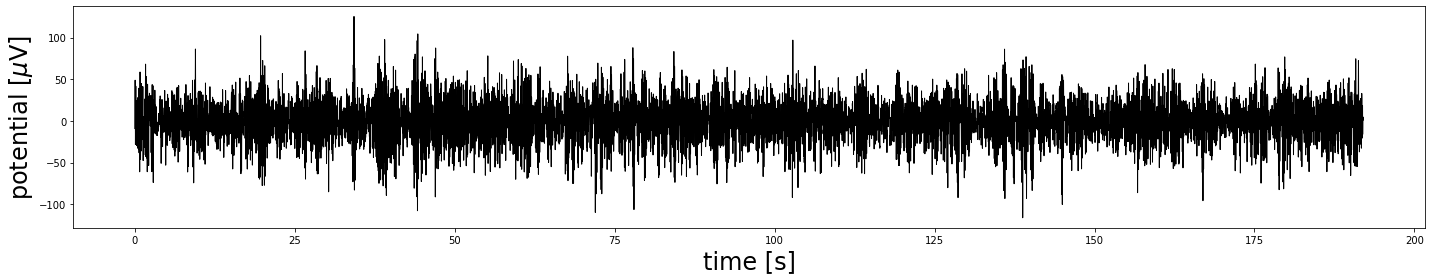

In [4]:
pca = PCA(copy=True, n_components=1, whiten=False)
pca1 = pca.fit_transform(data)[:,0]
plot_data(pca1, fs)

Alternatively, only a segment of data can be visualized to better recognize alpha oscillations.

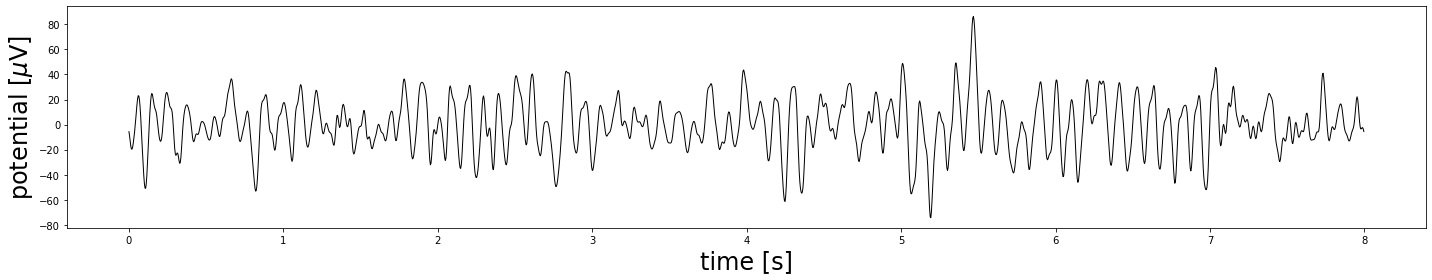

In [5]:
t0, t1 = 1000, 3000
plot_data(pca1[t0:t1], fs)

## (4) Clustering of the microstate maps

We are now ready to apply the microstate clustering algorithm to the filtered data. We implemented five different clustering methods (AAHC, modified k-means, k-medoids, PCA, Fast-ICA), as detailed in [4].  
Here, we will run the modified K-means algorithm as given by Pascual-Marqui [1], implemented as the function 'kmeans' in the eeg_microstates.py file [3]. The function variables should be self-explaining and are further documented in the source file following the PEP 8 styleguide.    
As the initial microstate ordering returned by the stochastic K-means algorithm is random, we provide a tool to re-label the microstates interactively. The standard ordering follows the geometry of the maps. Map A has a diagonal direction connecting the upper (frontal) left and lower (occipital) right corners, map B is diagonal in the opposite direction, map C has a horizontal orientation and map D is often circular. Sometimes, slightly different maps are generated. We mostly observed the occurrence of a map D with a vertical axis instead of a circular pattern. In this case, you can either accept the results and proceed, or re-cluster the data set as the results of the K-means algorithm differ between runs.
Modified K-means clustering and all information-theoretical computations can be run for any number of microstates. The desired number of microstates is given by the user as the argument 'n_maps' of the 'kmeans' function. If n_maps is not provided, the default value n_maps=4 is used.

In [6]:
mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"][1]
print(f"Clustering algorithm: {mode:s}")

Clustering algorithm: kmeans


[+] Data format for clustering [GFP peaks, channels]: 4130 x 30

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 33 iterations.
	K-means run 2/5 converged after 39 iterations.
	K-means run 3/5 converged after 43 iterations.
	K-means run 4/5 converged after 31 iterations.
	K-means run 5/5 converged after 94 iterations.
[+] Computation time: 1.41 sec

[+] Microstate back-fitting:
data_norm:  (48000, 30)
data_cluster_norm:  (4130, 30)
maps:  (4, 30)

[+] Global explained variance GEV = 0.686
GEV_0: 0.250
GEV_1: 0.174
GEV_2: 0.102
GEV_3: 0.160


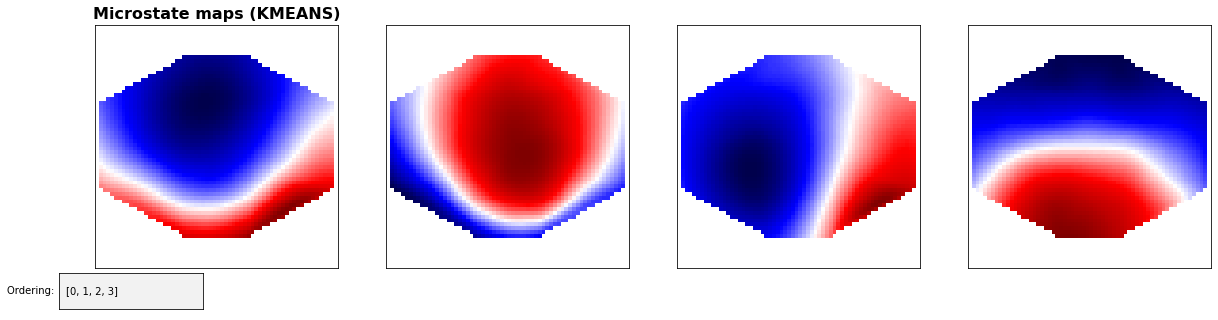

Re-ordered labels: 0, 1, 2, 3


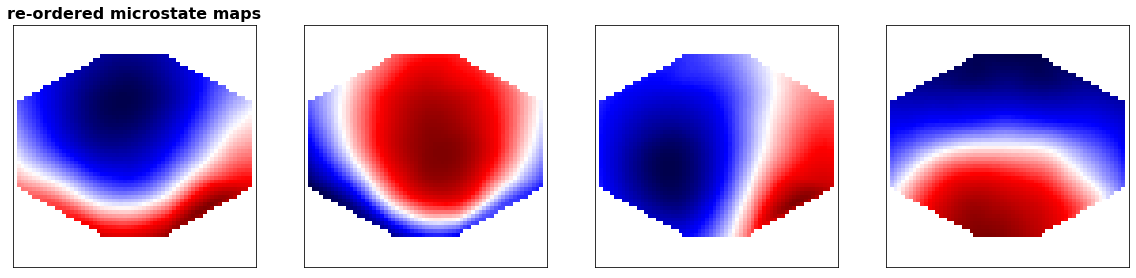

In [8]:
n_maps = 4
locs = []
maps, x, gfp_peaks, gev = clustering(data, fs, chs, locs, mode, n_maps, interpol=False, doplot=True)

You can also inspect the source code of the function:

In [ ]:
import inspect
#c=inspect.getsourcelines(kmeans) # activate by uncomment
#for l in c[0]: print(l)

When the algorithm terminates, the global explained variance (GEV) of the computed microstate time series is shown. For the test file, the GEV should give approximately 0.73. In other words, the microstate sequence explains ca. 73% of the electrical potential's spatial variance over time.  

The first return variable of the kmeans function is an array containing the microstate maps row-wise. The second return variable is the microstate sequence corresponding to the EEG data that was used as input. The sequence was generated as part of the kmeans optimizations by back-fitting into the EEG time series, and the sequence corresponding to the best K-means run is returned.  
On this sequence all subsequent tests will be run. The sequence contains the microstate labels as numbers, $\{A, B, C, D\} \rightarrow \{0, 1, 2, 3\}$, in order to accelerate information-theoretical computations. Using numbers, the microstate label can directly be used as an index in arrays and matrices. If you want to test microstate sequences generated by other another software, the sequence must be converted to numerical values $0, ..., n_{maps}-1$ before using the functions of this package.

## (5) Basic microstate statistics

We will now look at some basic statistical properties of the microstate sequence returned by the kmeans function. The empirical symbol distribution $\hat{p}$ quantifies the relative frequency of each microstate map. It is equivalent to the so-called 'ratio of time covered' (RTT) used in some EEG microstate publications. The transition matrix $\hat{T}$ contains the transition probabilities between all pairs of microstate labels. To get a feeling of the temporal dynamics of the EEG's spatial variance, we also compute the number of GFP peaks per second. The value is roughly 2 x the dominant EEG frequency band. In our case, the dominant frequency is a 10 Hz alpha rhythm and we observe approx. 21.5 GFP peaks per second.

In [9]:
p_hat = p_empirical(x, n_maps)
T_hat = T_empirical(x, n_maps)
print("\nEmpirical symbol distribution (RTT):\n")
for i in range(n_maps):
    print(f"p_{i:d} = {p_hat[i]:.3f}")
print("\nEmpirical transition matrix:\n")
print_matrix(T_hat)
pps = len(gfp_peaks) / (len(x)/fs)  # peaks per second
print(f"\nGFP peaks per sec.: {pps:.2f}")
print("\nGlobal explained variance (GEV) per map:")
for i, g in enumerate(gev): print(f"GEV(ms-{i:d}) = {gev[i]:.2f}")
print(f"\ntotal GEV: {gev.sum():.3f}")


Empirical symbol distribution (RTT):

p_0 = 0.237
p_1 = 0.282
p_2 = 0.219
p_3 = 0.261

Empirical transition matrix:

|0.7770.0800.0880.055|
|0.0630.8030.0580.076|
|0.0600.0810.7610.098|
|0.0850.0720.0570.786|

GFP peaks per sec.: 21.51

Global explained variance (GEV) per map:
GEV(ms-0) = 0.25
GEV(ms-1) = 0.17
GEV(ms-2) = 0.10
GEV(ms-3) = 0.16

total GEV: 0.686


## (6) Shannon entropy and entropy rate of the microstate sequence

The information-theoretical characterization of the microstate time series starts with the calculation of the empirical Shannon entropy $\hat{H}$ of the sequence:

$$
\begin{align}
\hat{H} & = -\sum_i \hat{p}(i) \log \hat{p}(i)
\end{align}
$$

where the index $i$ runs over the microstate labels. The base of the logarithm is not important. We use the natural logarithm to the base $e$ (Euler's number) and therefore measure information in 'nats', in analogy to bits when using $\log_2$.

In [10]:
h_hat = H_1(x, n_maps)
h_max = max_entropy(n_maps)
print(f"\nEmpirical entropy H = {h_hat:.2f} (max. entropy: {h_max:.2f})")


Empirical entropy H = 1.38 (max. entropy: 1.39)


The maximum entropy possible for any sequence composed of four symbols is $\log(4) \approx 1.39$, and the minimum entropy is zero. We see that the test sequence almost achieves the maximum entropy. As entropy can be interpreted as the amount of surprise or randomness, this result suggests a lack of predictable temporal features in the microstate sequence. However, we will show that the sequence does contain temporal structure, mainly in the form of periodicities in the range of the main EEG frequency bands.

Next, the entropy rate of the sequence is estimated from a set of joint Shannon entropies $H_k=H(\mathbf{X}_{n}^{(k)})$ for different history lengths $k$. The estimated entropy rate is the slope of the linear fit $k$ vs. $H_k$. The intercept is the so-called excess entropy, which is not further investigated here.

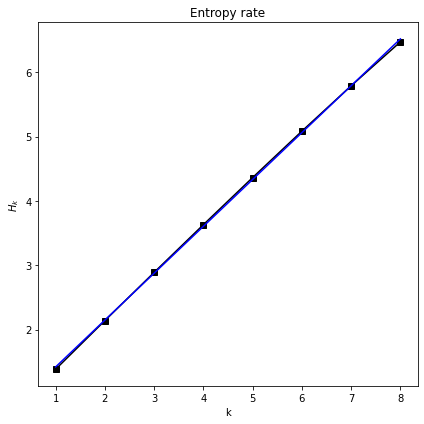


Empirical entropy rate h = 0.73
Theoretical MC entropy rate h = 0.76


In [11]:
h_rate, _ = excess_entropy_rate(x, n_maps, kmax=8, doplot=True)
h_mc = mc_entropy_rate(p_hat, T_hat)
print(f"\nEmpirical entropy rate h = {h_rate:.2f}")
print(f"Theoretical MC entropy rate h = {h_mc:.2f}")

## (7) Markov tests

We will first test the Markov properties of order 0, 1 and 2 for the EEG test file. For the details of the testing procedure, see the attached manuscript and the code documentation in the source file.

In [12]:
alpha = 0.01
p_M0 = testMarkov0(x, n_maps, alpha)
p_M1 = testMarkov1(x, n_maps, alpha)
p_M2 = testMarkov2(x, n_maps, alpha)
p_vals_geo = geoTest(x, n_maps, 1000./fs, alpha)

\ZERO-ORDER MARKOVIANITY:
p: 0.00e+00 | t: 59954.303 | df: 9.0

FIRST-ORDER MARKOVIANITY:
p: 3.83e-123 | t: 695.807 | df: 36.0

SECOND-ORDER MARKOVIANITY:
p: 2.38e-81 | t: 742.497 | df: 144.0

GEOMETRIC DISTRIBUTION of lifetimes:


Testing the distribution of symbol # 0
p: 1.21e-16 | t: 136.814 | df: 27.0
G-test (log-likelihood) p: 2.31e-06, g: 74.737, df: 27.0
G-test (Pearson Chi2) p: 2.38e-05, g: 67.687, df: 27.0

Testing the distribution of symbol # 1
p: 1.39e-65 | t: 390.859 | df: 28.0
G-test (log-likelihood) p: 8.90e-31, g: 215.175, df: 28.0
G-test (Pearson Chi2) p: 8.43e-27, g: 194.229, df: 28.0

Testing the distribution of symbol # 2
p: 2.91e-13 | t: 123.242 | df: 30.0
G-test (log-likelihood) p: 5.48e-05, g: 69.609, df: 30.0
G-test (Pearson Chi2) p: 5.12e-04, g: 62.079, df: 30.0

Testing the distribution of symbol # 3
p: 2.39e-23 | t: 180.145 | df: 30.0
G-test (log-likelihood) p: 5.98e-09, g: 96.762, df: 30.0
G-test (Pearson Chi2) p: 6.35e-08, g: 90.097, df: 30.0


The statistical Markovianity test show that our test sequence does not have the Markov property of the tested orders. This means that there are memory effects in the series which we will further explore.

## (8) Stationarity test

Next, we will test if the transition matrix $\hat{T}$ is time-stationary or if the matrix elements change significantly over time. You can provide a specific window length L for testing or use the default value of 5000 samples.

In [13]:
try:
    L = int(input("Enter block size: "))
except:
    L = 5000
p3 = conditionalHomogeneityTest(x, n_maps, L, alpha)

Enter block size: 2500

CONDITIONAL HOMOGENEITY (three-way table):
Split data in r = 19 blocks of length 2500.
p: 2.10e-12 | t: 392.765 | df: 216.0


We find that the given transition matrix is not time-stationary.

## (9) Symmetry test

We will now test if the transition matrix is symmetric. In other words, we test if the transitions $A \rightarrow B$ and $B \rightarrow A$ occur with the same probability or not.

In [14]:
p4 = symmetryTest(x, n_maps, alpha)


SYMMETRY:
p: 2.71e-55 | t: 269.547 | df: 6.0


The transition matrix of the test microstate sequence is not symmetric.

## (10) Markov surrogate example

To test our statistical procedures and to construct surrogate data sets from which confidence intervals for further information-theoretical quantities can be computed, we will synthesize first-order Markov chains with symbol distribution and transition matrix identical to the experimental EEG data set. This is possible because a first-order Markov chain is completely defined by an initial symbol distribution and a transition matrix for first-order (single time step) transitions.

In [15]:
x_mc = surrogate_mc(p_hat, T_hat, n_maps, len(x))
p_surr = p_empirical(x_mc, n_maps)
T_surr = T_empirical(x_mc, n_maps)
print("\nSurrogate symbol distribution:\n")
for i in range(n_maps):
    print(f"p_{i:d} = {p_surr[i]:.3f}")
print( "\nSurrogate transition matrix:\n" )
print_matrix(T_surr)


Surrogate symbol distribution:

p_0 = 0.228
p_1 = 0.283
p_2 = 0.220
p_3 = 0.268

Surrogate transition matrix:

|0.7690.0830.0920.057|
|0.0640.8030.0590.075|
|0.0570.0790.7650.100|
|0.0830.0730.0530.791|


We observe that the symbol distribution and the transition matrix are equivalent, within some stochastic margin, to the experimental data. A quantitative analysis of Markov surrogate errors is contained in [2].

## (11) Markov tests for surrogate Markov data

It will now be shown that the Markov surrogates fulfill the expected properties, or vice versa, that our Markovianity and stationarity tests work well with our surrogate data. This means that we can analyze experimental data series to find memory effects beyond a first-order Markov model.

In [16]:
p_M0_mc = testMarkov0(x_mc, n_maps, alpha)
p_M1_mc = testMarkov1(x_mc, n_maps, alpha)
p_M2_mc = testMarkov2(x_mc, n_maps, alpha)
p_vals_geo_mc = geoTest(x_mc, n_maps, 1000./fs, alpha)

\ZERO-ORDER MARKOVIANITY:
p: 0.00e+00 | t: 59982.540 | df: 9.0

FIRST-ORDER MARKOVIANITY:
p: 8.83e-01 | t: 26.268 | df: 36.0

SECOND-ORDER MARKOVIANITY:
p: 3.53e-01 | t: 149.818 | df: 144.0

GEOMETRIC DISTRIBUTION of lifetimes:


Testing the distribution of symbol # 0
p: 4.78e-01 | t: 28.756 | df: 29.0
G-test (log-likelihood) p: 9.91e-01, g: 14.005, df: 29.0
G-test (Pearson Chi2) p: 9.95e-01, g: 13.251, df: 29.0

Testing the distribution of symbol # 1
p: 1.61e-02 | t: 50.167 | df: 31.0
G-test (log-likelihood) p: 8.49e-01, g: 23.011, df: 31.0
G-test (Pearson Chi2) p: 8.78e-01, g: 22.153, df: 31.0

Testing the distribution of symbol # 2
p: 7.03e-02 | t: 48.015 | df: 35.0
G-test (log-likelihood) p: 9.80e-01, g: 20.073, df: 35.0
G-test (Pearson Chi2) p: 9.94e-01, g: 17.497, df: 35.0

Testing the distribution of symbol # 3
p: 8.09e-01 | t: 26.701 | df: 34.0
G-test (log-likelihood) p: 1.00e+00, g: 13.038, df: 34.0
G-test (Pearson Chi2) p: 1.00e+00, g: 12.138, df: 34.0


The Markov surrogate clearly fulfills the expected theoretical properties. The zero-order Markov hypothesis is rejected while the first-order and second-order properties are accepted. The theoretically equivalent, but numerically different test for geometric lifetime distributions asserts the geometric lifetime distribution of all microstate maps.

## (12) Stationarity test for surrogate Markov data

We expect the Markov surrogate to be time-stationary as the same transition matrix has been used to generate the entire sequence. The test results show that indeed, the Markov surrogate is correctly classified as time-stationary. This means that we can identify non-stationarity in experimental data sets statistically.

In [17]:
try:
    L = int(input("Enter block size: "))
except:
    L = 5000
p3_mc = conditionalHomogeneityTest(x_mc, n_maps, L, alpha)

Enter block size: 3000

CONDITIONAL HOMOGENEITY (three-way table):
Split data in r = 16 blocks of length 3000.
p: 8.58e-01 | t: 159.814 | df: 180.0


## (13) Symmetry test for surrogate Markov data

As the experimental EEG transtion matrix is used to generate the Markov surrogate, the surrogate's transition matrix is also asymmetric.

In [18]:
p4_mc = symmetryTest(x_mc, n_maps, alpha)


SYMMETRY:
p: 1.03e-63 | t: 308.866 | df: 6.0


## (14) Time-lagged mutual information: empirical vs. Markov

Mutual information for time lag k, $I(k)$, is defined as the difference between the entropy (uncertainty) of the microstate sequence at time point $t+k$, and the conditional entropy at time point $t+k$ given the state at time $t$. Mutual information thus quantifies the uncertainty about the state at $t+k$ that is not represented by the previous time point $t$.

$$
\begin{align}
I(k) & = H(X_{t+k}) - H(X_{t+k} \mid X_k)
\end{align}
$$

As an analogy to the autocorrelation function (ACF) for metric time series, we will call this information-theoretic quantity the autoinformation function (AIF). Whilte the ACF uses linear correlation as a dependency measure for metric time series, the AIF uses mutual information to quantify dependencies in symbolic sequences.  
We can now compute the time-lagged mutual information function of the microstate sequence and compare it to a set of Markov surrogates, from which a confidence interval under the first-order Markovian null hypothesis is constructed. We here use 10 Markov surrogates and compute the two-sided 99% percentile.  

In [19]:
l_max = 100
n_mc = 10
aif = mutinf(x, n_maps, l_max)
print(f"\nComputing n = {n_mc:d} Markov surrogates...\n")
aif_array = mutinf_CI(p_hat, T_hat, len(x), alpha, n_mc, l_max)
pct = np.percentile(aif_array,[100.*alpha/2.,100.*(1-alpha/2.)],axis=0)
print("\nMarkov surrogates and AIF confidence interval computed")

mutual information lag: 100

Computing n = {n_mc:d} Markov surrogates...


surrogate MC # 1/10
mutual information lag: 100

surrogate MC # 2/10
mutual information lag: 100

surrogate MC # 3/10
mutual information lag: 100

surrogate MC # 4/10
mutual information lag: 100

surrogate MC # 5/10
mutual information lag: 100

surrogate MC # 6/10
mutual information lag: 100

surrogate MC # 7/10
mutual information lag: 100

surrogate MC # 8/10
mutual information lag: 100

surrogate MC # 9/10
mutual information lag: 100

surrogate MC # 10/10
mutual information lag: 100


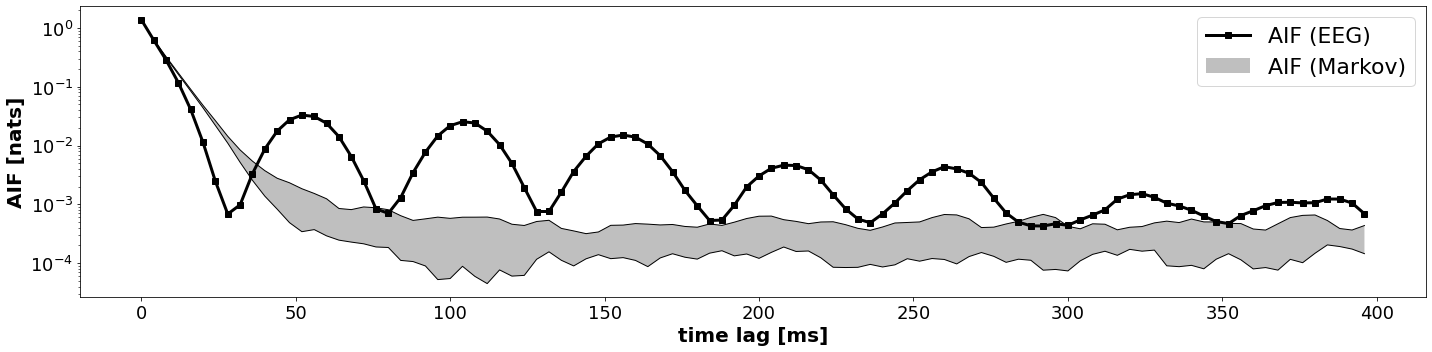

In [20]:
plt.ioff()
fig = plt.figure(1, figsize=(20,5))
fig.patch.set_facecolor('white')
t = np.arange(l_max)*1000./fs
plt.semilogy(t, aif, '-sk', linewidth=3, label='AIF (EEG)')
plt.semilogy(t, pct[0,:], '-k', linewidth=1)
plt.semilogy(t, pct[1,:], '-k', linewidth=1)
plt.fill_between(t, pct[0,:], pct[1,:], facecolor='gray', alpha=0.5, label='AIF (Markov)')
plt.xlabel("time lag [ms]", fontsize=20, fontweight="bold")
plt.ylabel("AIF [nats]", fontsize=20, fontweight="bold")
plt.legend(fontsize=22)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=18)
plt.tight_layout()
plt.show()

The figure generated by the code above shows the autoinformation function (AIF) along with Markovian confidence intervals. The AIF summarizes memory effects in the test microstate sequence as identified by mutual information. It is observed that the AIF of experimental data (black line and squares) shows clear periodicities and comparison with the Markovian confidence interval (gray-shaded area) shows that these peaks are statistically significant.  
We can thus show that EEG microstates recur in a regular way. In other words, the microstate sequences passes through the graph of state transitions in a circular way. The transitions do not do so in a completely deterministic way, as any state transition is possible at any time, but we show that there are preferred closed paths along the state transition graph.

## (15) Summary and reporting results

The results can be summarized for scientific reporting as follows. Please note that *fixed numerical values are shown here*, i.e. the results of a specifc run of the algorithm. As clustering results vary slightly between runs, the exact numerical values may differ from the results obtained above.

1. We analyzed 192 seconds of resting state EEG sampled at 250 Hz. The 1-35 Hz band-pass filtered data set showed  21.51 GFP peaks per second and was clustered into 4 microstates, labelled A-D.

2. Static properties:
    * The microstate distribution was $p(A)=0.222$, $p(B)=0.240$, $p(C)=0.264$, and $p(D)=0.275$.
    * The four microstates explained 69% of the total data variance (GEV).
    * In information-theoretical terms, the four microstates produced a Shannon entropy of $H=1.38$ nats, where the upper bound for a 4-state process is $H_{max}=1.39$ nats. The empirical entropy rate was $h=0.73$ nats, and the expected value for the analogous first-order Markov process is $h=0.76$ nats.

3. Dynamic properties:
    * The transition probabilities between all pairs of microstates are summarized in the transition matrix T:
    \begin{equation*}
    T =  \begin{vmatrix}
    0.771 & 0.094 & 0.058 & 0.076 \\
	0.063 & 0.769 & 0.112 & 0.056 \\
	0.063 & 0.055 & 0.786 & 0.096 \\
	0.070 & 0.072 & 0.061 & 0.797 \\
    \end{vmatrix}
    \end{equation*}
    * The transition matrix T proved to be asymmetric ($p \lt 10^{-80}$).

4. Information-theoretical properties. Using a significance level of $\alpha = 0.01$, we found that:
    * The microstate sequence does not fulfill the Markov property of order 0, 1, or 2. We conclude that the microstate sequence has extended memory effects.
    * During the EEG recording, the transition matrix of the microstate sequence is not constant (it is non-stationary), when tested for a partition into 9 blocks and 5000 samples per block ($p=3.37 \times 10^{-6}$). This result should be taken as a precaution when using methods that require time stationarity (e.g. long-range memory interpretations of Hurst exponents).
    * Non-Markovianity and non-stationarity are at least partially explained by a periodic recurrence of the microstates, as shown by the time-lagged mutual information function (or autoinformation function, AIF). For time lags up to 400 msec., the EEG's AIF lies above the (first-order) Markov confidence interval and shows distinct peaks at multiples of approx. 50 msec (half the period of the underlying alpha rhythm).


### Code acceleration

If you ran the code above on your computer, you will have noticed that the AIF calculation determines the computation time of the procedure. The code can be accelerated using Cython, Numba or an external Julia function, for instance. To maximize portability and minimize the number of operating system dependencies, we did not include these accelerations in the code. However, the mentioned methods are implemented with little effort. Accelerated code can also be obtained from the author.
The eeg_microstates.py script can be run from the console using the -mc parameter that defines the number of Markov surrogates. The number of surrogates will define the width and smoothness of the confidence interval. Empirically, we suggest a minimum number of 50-100 surrogates.

## Conclusions

If you have arrived here, you should have completed the tutorial successfully. You should be familiar with the functionality provided by this software and have a good impression how to process larger data sets to obtain group statistics.